# Welcome to our PyTorch Lab for Fashion MNIST

We are going to use the Fashion-MNIST dataset, a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

**Our agenda for today:**

1. Download Fashion data and split them into train set and test set
2. Apply appropriate transforms (converting to tensor and normalize them)
3. Setup CNN network
4. Set up TensorBoard.
5. Train our model and write to TensorBoard.
6. Inspect a model architecture using TensorBoard.

In [0]:
# imports numpy and mathplotlib libraries 
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# imports torch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [0]:
# import ngrok library to display TensorBoard on Colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-04-20 02:29:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.231.129.73, 52.72.182.203, 34.192.215.160, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.231.129.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  19.3MB/s    in 0.7s    

2020-04-20 02:29:50 (19.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
# transforms to convert our data to tensors and normalize them
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [0]:
# use pytorch datasets to download the Fashion MNIST data, in this case, we will split them into trainset and testset.
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

In [0]:
# use pytorch dataloaders to load our train set and test set into batch automatically for training process and test process.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [0]:
# constant for classes (10 classes in total)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


## Custom nn Modules

Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
summary(net.cuda(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


## Sequential Module

Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In TensorFlow, packages like Keras, TensorFlow-Slim, and TFLearn provide higher-level abstractions over raw computational graphs that are useful for building neural networks.

In PyTorch, the nn package serves this same purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In this case, we will use Sequential Module. Firstly, we use the nn package to define our model as a sequence of layers. The Sequential is a Module which contains other Modules, and applies them in sequence to produce its output. Each Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.

In [0]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(-1, 16 * 4 * 4)

In [0]:
net = torch.nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

In [0]:
summary(net.cuda(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                  [-1, 120]          30,840
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
---------------------------------

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

This is how you setup the TensorBoard.

In [0]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [0]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

This is how you write information in the TensorBoard.

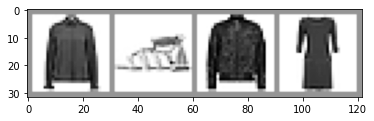

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [0]:
writer.add_graph(net, images)
writer.close()

Let's see our graph on tensorboard!

In [0]:
# This will bind the localhost port 6006 of tensorboard to ngrok outside on internet so you can access to your tensorboard anywhere 
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
!tensorboard --logdir=runs

We can visualize the lower dimensional representation of higher dimensional data via the add_embedding method.
Now in the “Projector” tab of TensorBoard, you can see these 100 images - each of which is 784 dimensional - projected down into three dimensional space. Furthermore, this is interactive: you can click and drag to rotate the three dimensional projection. Finally, a couple of tips to make the visualization easier to see: select “color: label” on the top left, as well as enabling “night mode”, which will make the images easier to see since their background is white.

In [0]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

Let's see the 3D Projection of our data on tensorboard!

In [0]:
# This will bind the localhost port 6006 of tensorboard to ngrok outside on internet so you can access to your tensorboard anywhere 
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
!tensorboard --logdir=runs

We will log the running loss to TensorBoard, along with a view into the predictions the model is making via the plot_classes_preds function.

In [0]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finally, let’s train the model using the same model training code from the prior tutorial, writing results to TensorBoard every 1000 batches and printing to console; this is done using the add_scalar function.

In addition, as we train, we’ll generate an image showing the model’s predictions vs. the actual results on the four images included in that batch.

We should see all of that in the tensorboard!

In [0]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            print('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

training loss 2.050788370847702 999
training loss 0.9156462009567767 1999
training loss 0.715763332651928 2999
training loss 0.6537347045959905 3999
training loss 0.5908949752859771 4999
training loss 0.5474071331294253 5999
training loss 0.4933299799661618 6999
training loss 0.49030346160253974 7999
training loss 0.48259477493469605 8999
training loss 0.453785642052826 9999
training loss 0.45188969594729134 10999
training loss 0.44831116875307636 11999
training loss 0.4129221609237138 12999
training loss 0.40040553867060225 13999
training loss 0.39087228658905954 14999
Finished Training


Let's check our result in the tensorboard!

In [0]:
# This will bind the localhost port 6006 of tensorboard to ngrok outside on internet so you can access to your tensorboard anywhere 
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
!tensorboard --logdir=runs

https://a90c7790.ngrok.io
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


Phew, that is a lot to learn and process! I hope this tutorial/lab will serve as a good example of computer vision PyTorch project!

If you want to learn more, please check the official tutorial on the PyTorch websites. They got the best documentation and tutorial projects to learn: https://pytorch.org/tutorials/